<a href="https://colab.research.google.com/github/KryssyCo/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Krista_Shepard_DS5_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=409.3526525680556, mobile=False), User(purchased=True, time_on_site=377.74506414945944, mobile=False), User(purchased=True, time_on_site=68.08444972688368, mobile=True), User(purchased=False, time_on_site=65.22813602223805, mobile=True), User(purchased=False, time_on_site=545.7640088220944, mobile=False), User(purchased=False, time_on_site=467.99253686858674, mobile=False), User(purchased=False, time_on_site=234.0457710259489, mobile=False), User(purchased=True, time_on_site=44.87937266715289, mobile=True), User(purchased=False, time_on_site=35.753153003155674, mobile=True), User(purchased=False, time_on_site=12.110755842522385, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,409.352653,False
1,True,377.745064,False
2,True,68.084450,True
3,False,65.228136,True
4,False,545.764009,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.787582735463338,7.0702440768686925,7.287384037812043,10.300298784854167,10.395499690021328,10.47034687289845,11.456651396253285,11.658601742061984,12.02187812889456,12.076611518249193,12.110755842522385,12.38666006354121,12.419185840008247,12.433088562028288,12.871071916607265,14.451724227880009,14.642499786961931,14.886735362823885,14.976947406395471,15.419058166932045,15.441092418557723,15.988721817295717,16.480227710636882,16.49558134240717,18.687851300832772,19.067651036159774,19.6179001388816,19.796340922086202,20.434862623725497,20.768277646347933,20.916860525445564,22.16591674551605,22.324990048435268,22.46801114164497,22.767580718001934,22.910844348977125,23.165170481806427,23.1788982195547,23.40956658127637,23.43571455514964,...,523.7441980488485,523.9945761812565,527.4758791896779,528.1180588910755,528.2099780068028,530.1879261600956,530.369030693012,535.991390653555,536.6067385556811,537.8860948422077,540.8223139433452,545.7640088220944,545.8237164741969,554.9796554836219,556.5755880885664,557.973567131365,558.0454641508555,558.0791933876134,558.3855907425376,558.9903264127678,560.4319510429704,561.539306653916,562.4213138981113,563.2557502892968,567.4734661265366,571.6171168537292,572.832468833871,574.1790257992214,574.5948689584783,576.2449379384352,579.972539635107,581.846667755974,588.3769449126057,591.3875152541247,591.79575045515,591.8316706595375,592.3539743939579,592.9295195798333,593.3902249456487,598.049182307906
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,1,1,0,0,1,0,1,0,1,0,0,1,1
True,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,1,0,1,0,1,1,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.195, 124.24]","(124.24, 242.692]","(242.692, 361.145]","(361.145, 479.597]","(479.597, 598.049]"
purchased,,,,,
False,225,215,108,25,35
True,106,144,93,24,25


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.195, 124.24]","(124.24, 242.692]","(242.692, 361.145]","(361.145, 479.597]","(479.597, 598.049]"
purchased,,,,,
False,0.679758,0.598886,0.537313,0.510204,0.583333
True,0.320242,0.401114,0.462687,0.489796,0.416667


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.66,0.590667
True,0.34,0.409333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
import pandas as pd
persons = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')
persons.head

<bound method NDFrame.head of       Unnamed: 0  age  weight  exercise_time
0              0   44     118            192
1              1   41     161             35
2              2   46     128            220
3              3   39     216             57
4              4   28     116            182
5              5   58     103            165
6              6   55     161            107
7              7   21     188             37
8              8   55     216             79
9              9   50     127            267
10            10   21     160            228
11            11   43     102             78
12            12   73     209             44
13            13   27     165             48
14            14   21     169            171
15            15   36     131            194
16            16   49     171            191
17            17   69     172            147
18            18   18     122            271
19            19   55     157            111
20            20   19    

**My hypothesis is that people who spend more time exercising, will weigh less. So a persons weight is dependant on how much time they exercise. However, their age is definitely a confounding relationship, because their has been medical research that has shown that it is harder to lose weight as you get older. Also, I think a significant piece of data is missing, specifically, the biological gender of the person or people in question.**

In [0]:
from collections import namedtuple
# age, weight and exercise time are all ints = age in years, weight in pounds
# and exercise time in minutes.
people = namedtuple('people', ['age', 'exercise_time', 'weight'])
example_people = people(24, 30, 118)
print(example_people)
# Just FYI I follow each step from lecture the first time, and get brave once 
# concepts are clear to me.

people(age=24, exercise_time=30, weight=118)


In [0]:
persons.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [0]:
persons.dtypes # type of data = integers

  

Unnamed: 0       int64
age              int64
weight           int64
exercise_time    int64
dtype: object

In [0]:
persons.isnull().sum() # No missing data

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

In [0]:
pd.crosstab(persons['weight'], persons['exercise_time'])

#Used crosstabulation to try to see what is going on, and if you took a lot of 
#time, I'm sure you could draw some sort of conclusion, but it would be very time 
#consuming. The current results show exercise_time by the minute. I need bins!

exercise_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,296,297,298,299,300
weight,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0


In [0]:
!pip install pandas==0.23.4

In [0]:
import numpy as np
time_bins = pd.cut(persons['exercise_time'],bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270,300, np.inf] )
pd.crosstab(persons['weight'], time_bins)


 # I also got the pandas error and had to address it.
 # Analyzing this information, one might think, my initial hypothesis 
 # was correct. The amount of time does seem to have an effect on weight. 
 # The more time spent exercising the more people in the weight class.

exercise_time,"(0.0, 30.0]","(30.0, 60.0]","(60.0, 90.0]","(90.0, 120.0]","(120.0, 150.0]","(150.0, 180.0]","(180.0, 210.0]","(210.0, 240.0]","(240.0, 270.0]","(270.0, 300.0]"
weight,,,,,,,,,,
100,3,2,1,0,0,1,2,2,1,3
101,0,0,1,0,1,1,3,2,1,1
102,1,0,2,0,2,1,0,3,1,3
103,1,0,1,1,0,2,0,0,0,3
104,1,1,1,1,1,0,0,2,1,1
105,3,0,0,0,0,2,1,0,1,3
106,0,1,0,2,0,2,1,0,1,1
107,0,0,1,1,2,2,2,1,2,0
108,0,1,2,0,3,3,2,2,3,3


In [0]:
pd.crosstab(persons['weight'], time_bins, normalize ='columns') 
#Normalizing the columns doesn't seem to be accurate.  

exercise_time,"(0.0, 30.0]","(30.0, 60.0]","(60.0, 90.0]","(90.0, 120.0]","(120.0, 150.0]","(150.0, 180.0]","(180.0, 210.0]","(210.0, 240.0]","(240.0, 270.0]","(270.0, 300.0]"
weight,,,,,,,,,,
100,0.020408,0.015504,0.006098,0.000000,0.000000,0.008475,0.021277,0.020408,0.01,0.032967
101,0.000000,0.000000,0.006098,0.000000,0.009524,0.008475,0.031915,0.020408,0.01,0.010989
102,0.006803,0.000000,0.012195,0.000000,0.019048,0.008475,0.000000,0.030612,0.01,0.032967
103,0.006803,0.000000,0.006098,0.006579,0.000000,0.016949,0.000000,0.000000,0.00,0.032967
104,0.006803,0.007752,0.006098,0.006579,0.009524,0.000000,0.000000,0.020408,0.01,0.010989
105,0.020408,0.000000,0.000000,0.000000,0.000000,0.016949,0.010638,0.000000,0.01,0.032967
106,0.000000,0.007752,0.000000,0.013158,0.000000,0.016949,0.010638,0.000000,0.01,0.010989
107,0.000000,0.000000,0.006098,0.006579,0.019048,0.016949,0.021277,0.010204,0.02,0.000000
108,0.000000,0.007752,0.012195,0.000000,0.028571,0.025424,0.021277,0.020408,0.03,0.032967


In [0]:
# Now, I took a look at how age correlates with weight. I believe it will go up
# as people age, and being to slow down.

pd.crosstab(persons['age'], persons['weight'])

#Wow, I was really wrong

weight,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,233,234,236,237,238,239,240,241,242,244,246
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
25,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
26,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Taking a look at all three variables together.
ct = pd.crosstab(persons['exercise_time'], [persons['weight'], time_bins], 
rownames=['device'],colnames=['weight', 'age'],)

ct

# I really wish I would have bin'd age as well.



weight         100                  ...             244         246
age    (0.0, 30.0] (30.0, 60.0]     ...     (0.0, 30.0] (0.0, 30.0]
device                              ...                            
1                0            0     ...               0           0
2                1            0     ...               0           0
3                0            0     ...               0           0
4                1            0     ...               0           0
5                0            0     ...               0           1
6                0            0     ...               0           0
7                0            0     ...               0           0
8                0            0     ...               0           0
9                0            0     ...               0           0
10               0            0     ...               0           0
11               0            0     ...               0           0
12               0            0     ...               0           0
13               0            0     ...               0           0
14               0            0     ...               0           0
15               0            0     ...               0           0
16               0            0     ...               0           0
17               0            0     ...               0           0
18               1            0     ...               1           0
19               0            0     ...               0           0
20               0            0     ...               0           0
21               0            0     ...               0           0
22               0            0     ...               0           0
23               0            0     ...               0           0
24               0            0     ...               0           0
25               0            0     ...               0           0
26               0            0     ...               0           0
27               0            0     ...               0           0
28               0            0     ...               0           0
30               0            0     ...               0           0
31               0            0     ...               0           0
...            ...          ...     ...             ...         ...
270              0            0     ...               0           0
271              0            0     ...               0           0
272              0            0     ...               0           0
273              0            0     ...               0           0
274              0            0     ...               0           0
275              0            0     ...               0           0
276              0            0     ...               0           0
277              0            0     ...               0           0
278              0            0     ...               0           0
279              0            0     ...               0           0
280              0            0     ...               0           0
281              0            0     ...               0           0
282              0            0     ...               0           0
283              0            0     ...               0           0
284              0            0     ...               0           0
285              0            0     ...               0           0
286              0            0     ...               0           0
287              0            0     ...               0           0
288              0            0     ...               0           0
289              0            0     ...               0           0
290              0            0     ...               0           0
291              0            0     ...               0           0
292              0            0     ...               0           0
293              0            0     ...               0           0
294              0            0     ...               0 

In [0]:
type(ct)

pandas.core.frame.DataFrame

In [0]:
#pivot table

pt = pd.pivot_table(persons, values= 'weight', index=time_bins)
pt

,weight
exercise_time,
"(0.0, 30.0]",177.387755
"(30.0, 60.0]",171.178295
"(60.0, 90.0]",162.073171
"(90.0, 120.0]",164.381579
"(120.0, 150.0]",152.380952
"(150.0, 180.0]",145.389831
"(180.0, 210.0]",140.340426
"(210.0, 240.0]",135.326531
"(240.0, 270.0]",131.560000


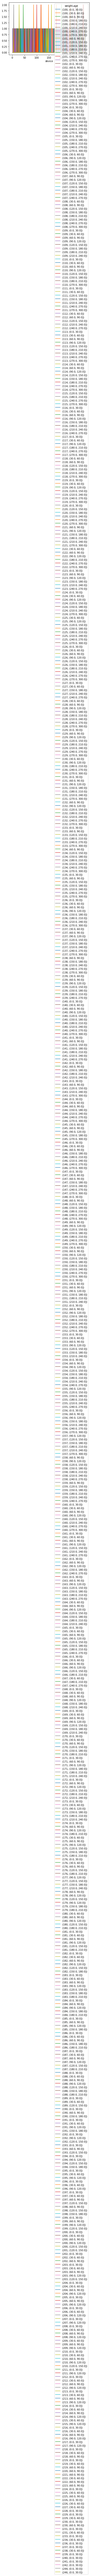

In [0]:
#Finally, a visual representation.
ct.plot();

#A line plot doesn't work for this data set, if I bin more variables, I think I
#can clean this up. I will come back and work on it and see.

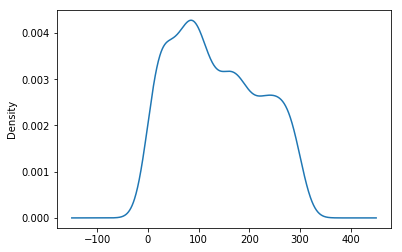

In [0]:
persons['exercise_time'].plot.density();
# Probably not the best representation

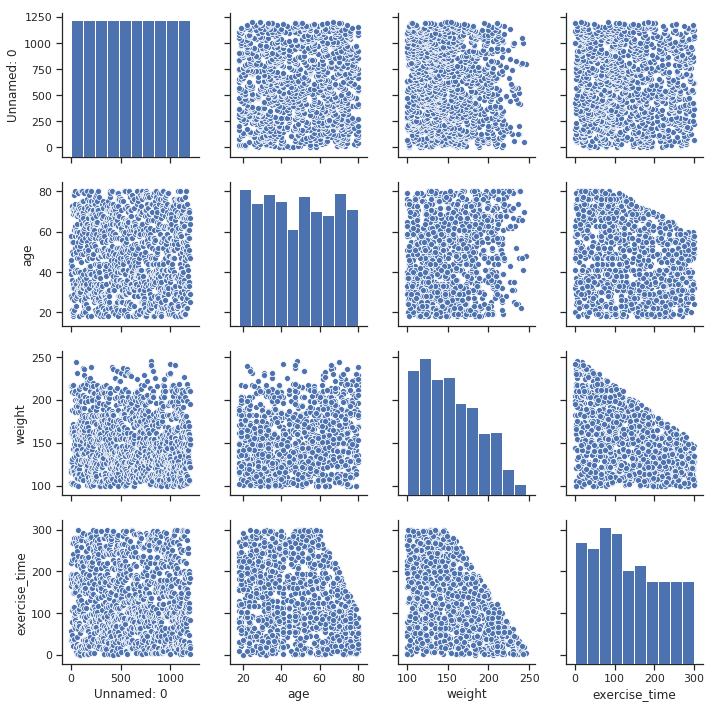

In [0]:
import seaborn as sns 

sns.set(style='ticks', color_codes=True)
graph = sns.pairplot(persons)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
**Integers, Continuous**
2.  What are the relationships between the variables?
**There is a correlation between all three variables.**
3.  Which relationships are "real", and which spurious?
**I believe all of the relationships are 'real.'**


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)